In [2]:
%pip install pyaurn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
#from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
metadata = pyaurn.importMeta().set_index("site_id")

In [6]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-09-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-09-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-09-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-09-30,South West,NaN,Teignbridge


In [7]:
def get_raw_data(name, year_range):
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    return data

In [8]:
def prepare_site_data(data: pd.DataFrame):
  try:
    if "temp" in data.columns:
      data = data.copy().reset_index()
      data.date = data.date.astype("datetime64[s]").astype("int64")
      data = data.dropna(subset=["temp"])
      data = data.interpolate(method="pad")
      data = data.merge(filtered_metadata, on="site_id").drop(["site_id", "site", "code"], axis=1)
      return data
  except KeyError:
    return

In [9]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_raw_data, name, range(2021, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [10]:
raw_data = [item.result() for item in all_data.done]
display(raw_data[2])

,index,site_id


In [11]:
usable_data = raw_data.copy()

display(usable_data[0])

,index,site_id


In [12]:
retrieved_data = [prepare_site_data(item) for item in usable_data]
display(retrieved_data)

[None,
       index                 date        NO       NO2   NOXasNO2     wd   ws  \
 0         0  1609459200000000000  35.32888  53.90462  108.07482    5.9  1.9   
 1         1  1609462800000000000   4.38021  37.05325   43.76947    2.5  1.9   
 2         2  1609466400000000000   6.16640  39.64113   49.09614    1.0  1.6   
 3         3  1609470000000000000   8.02440  39.68267   51.98657  358.1  1.0   
 4         4  1609473600000000000  11.57883  37.78373   55.53768    0.4  0.9   
 ...     ...                  ...       ...       ...        ...    ...  ...   
 8395   8755  1640977200000000000  10.48750  27.46628   43.54688  168.0  4.6   
 8396   8756  1640980800000000000   6.48746  24.03798   33.98527  171.0  6.0   
 8397   8757  1640984400000000000   5.04207  12.48342   20.21448  175.3  7.5   
 8398   8758  1640988000000000000   3.52945  11.73679   17.14853  172.5  8.2   
 8399   8759  1640991600000000000   2.28574   9.27870   12.78345  171.0  8.5   
 
       temp  location_type   la

In [13]:
concatenated_data = pd.concat(retrieved_data)[["date", "NO", "NO2", "NOXasNO2", "O3", "PM10", "PM2.5", "wd", "ws", "latitude", "longitude", "temp"]]
concatenated_data.info()
display(concatenated_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1433520 entries, 0 to 8399
Data columns (total 12 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   date       1433520 non-null  int64  
 1   NO         1319876 non-null  float64
 2   NO2        1319876 non-null  float64
 3   NOXasNO2   1319876 non-null  float64
 4   O3         616166 non-null   float64
 5   PM10       757864 non-null   float64
 6   PM2.5      668589 non-null   float64
 7   wd         1433520 non-null  float64
 8   ws         1433520 non-null  float64
 9   latitude   1433520 non-null  float64
 10  longitude  1433520 non-null  float64
 11  temp       1433520 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 142.2 MB


date              0
NO           113644
NO2          113644
NOXasNO2     113644
O3           817354
PM10         675656
PM2.5        764931
wd                0
ws                0
latitude          0
longitude         0
temp              0
dtype: int64

In [14]:
filled_data = concatenated_data.fillna(0).sort_values(by="date")
display(filled_data.isna().sum())

date         0
NO           0
NO2          0
NOXasNO2     0
O3           0
PM10         0
PM2.5        0
wd           0
ws           0
latitude     0
longitude    0
temp         0
dtype: int64

In [15]:
display(filled_data)

,date,NO,NO2,NOXasNO2,O3,PM10,PM2.5,wd,ws,latitude,longitude,temp
0,1609459200000000000,35.32888,53.90462,108.07482,0.00,0.000,0.000,5.9,1.9,53.747763,-2.452680,-0.3
0,1609459200000000000,3.44719,44.00694,49.29256,6.37,35.275,31.958,134.8,0.4,53.481520,-2.237881,-0.5
0,1609459200000000000,1.86838,4.42459,7.28940,0.00,7.250,4.835,255.4,2.8,57.481308,-4.241451,0.5
0,1609459200000000000,5.70377,16.14634,24.89200,0.00,0.000,0.000,283.8,3.6,55.944760,-3.183991,-0.2
0,1609459200000000000,0.00000,0.00000,0.00000,0.00,35.275,31.085,287.4,1.4,51.425286,-0.345606,-2.1
...,...,...,...,...,...,...,...,...,...,...,...,...
8399,1640991600000000000,0.39690,3.04049,3.64905,0.00,0.000,0.000,208.9,9.9,52.673471,-2.436692,11.3
8399,1640991600000000000,2.20336,4.33555,7.71399,0.00,0.000,0.000,196.3,5.4,52.821050,-1.635718,10.1
8399,1640991600000000000,1.03507,2.05431,3.64140,0.00,0.000,0.000,209.4,4.6,54.565819,-1.315900,8.7
8399,1640991600000000000,0.74064,3.97175,5.10739,0.00,12.561,12.000,194.0,6.1,54.516667,-1.358547,8.1


In [16]:
def split_dataset(dataset: pd.DataFrame):
    dataset_len = len(dataset)
    train_end = round(dataset_len * 0.7)
    val_end = round(dataset_len * 0.85)

    train_dataset = dataset.iloc[0:train_end].copy()
    # 15% of original dataset (0.3 * 0.5)
    val_dataset = dataset.iloc[train_end:val_end].copy()
    # Take what's left
    test_dataset = dataset.iloc[val_end:dataset_len].copy()
    
    return train_dataset.temp, train_dataset.drop("temp", axis=1), val_dataset.temp, val_dataset.drop("temp", axis=1), test_dataset.temp, test_dataset.drop("temp", axis=1)

In [17]:
train_targets, train_data, val_targets, val_data, test_targets, test_data = split_dataset(filled_data)

In [21]:
def save_fig(model_name: str, figname):
    folder_path = f"./models/{model_name}"
    fig_filename = f"/{figname}.png"
    try:
        os.makedirs(folder_path)
    except FileExistsError:
        pass
    plt.savefig(folder_path + fig_filename)
    plt.close()

In [20]:
inputs = tf.keras.layers.Input(len(train_data.columns))

normalisation = tf.keras.layers.Normalization()
normalisation.adapt(train_data)
normalisation = normalisation(inputs)

dense = tf.keras.layers.Dense(32, activation="relu")(normalisation)

outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
normalization_2 (Normalizati (None, 11)                23        
_________________________________________________________________
dense (Dense)                (None, 32)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 440
Trainable params: 417
Non-trainable params: 23
_________________________________________________________________


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

history = model.fit(
    train_data,
    train_targets,
    epochs=10,
    callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=1, min_lr=0.001),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
    ],
    validation_data=(val_data, val_targets)
)

Epoch 1/10
31359/31359 [==============================] - 130s 4ms/step - loss: 11.8914 - mean_absolute_error: 2.7187 - val_loss: 19.7670 - val_mean_absolute_error: 3.6516
Epoch 2/10
31359/31359 [==============================] - 131s 4ms/step - loss: 11.8318 - mean_absolute_error: 2.7136 - val_loss: 10.0479 - val_mean_absolute_error: 2.5417
Epoch 3/10
31359/31359 [==============================] - 118s 4ms/step - loss: 12.0303 - mean_absolute_error: 2.7368 - val_loss: 42.0751 - val_mean_absolute_error: 5.5795


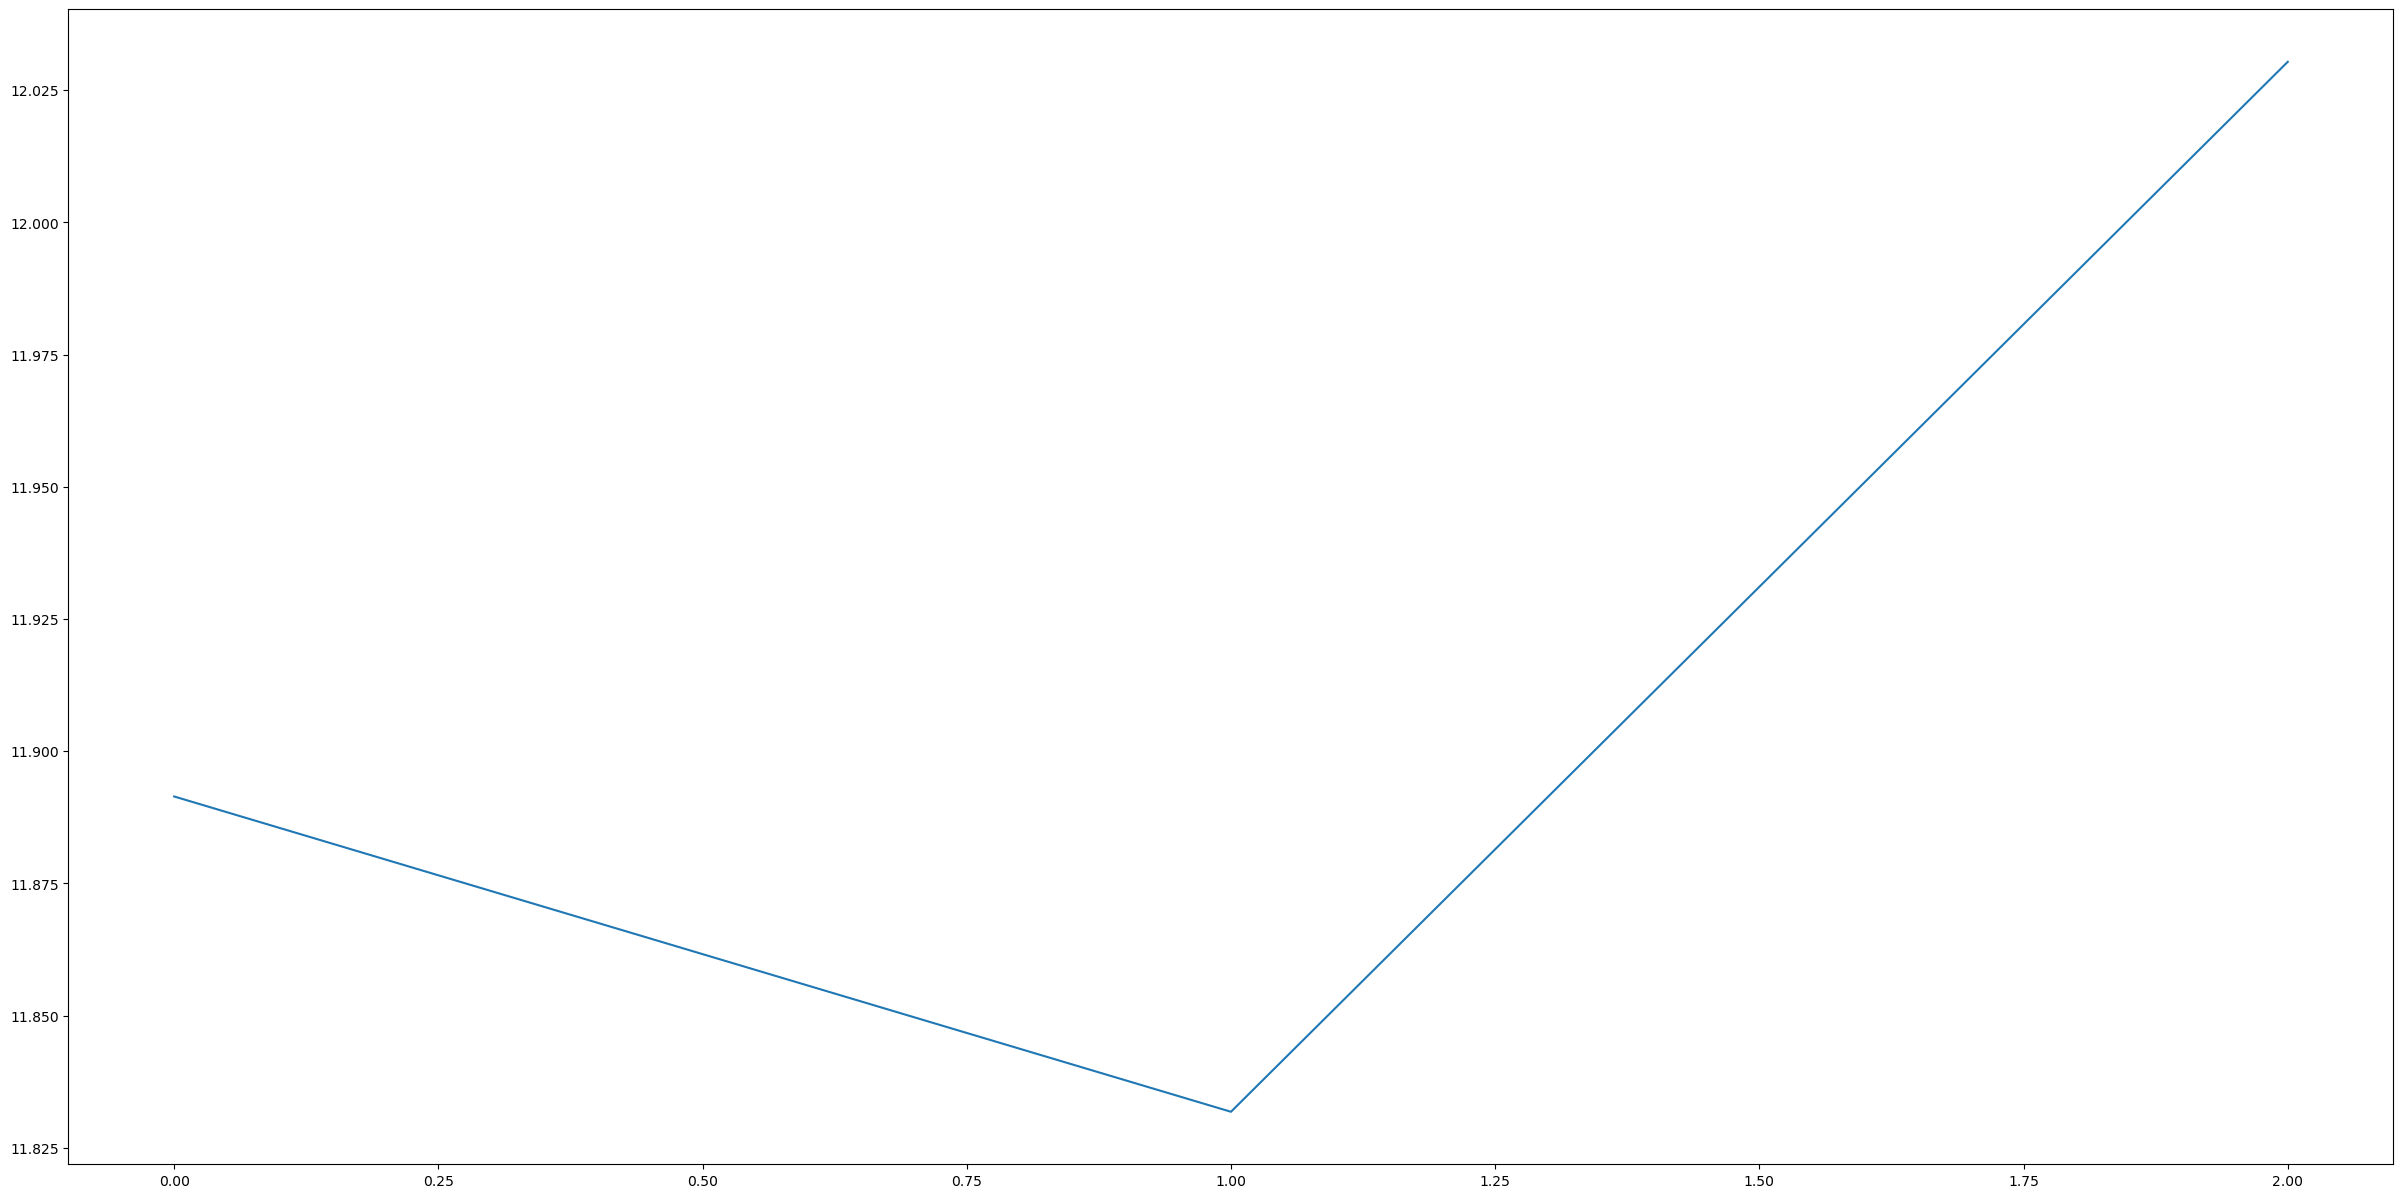

array([14.068739, 15.929916, 15.553715, ..., 13.577251, 13.941036,
       15.041548], dtype=float32)

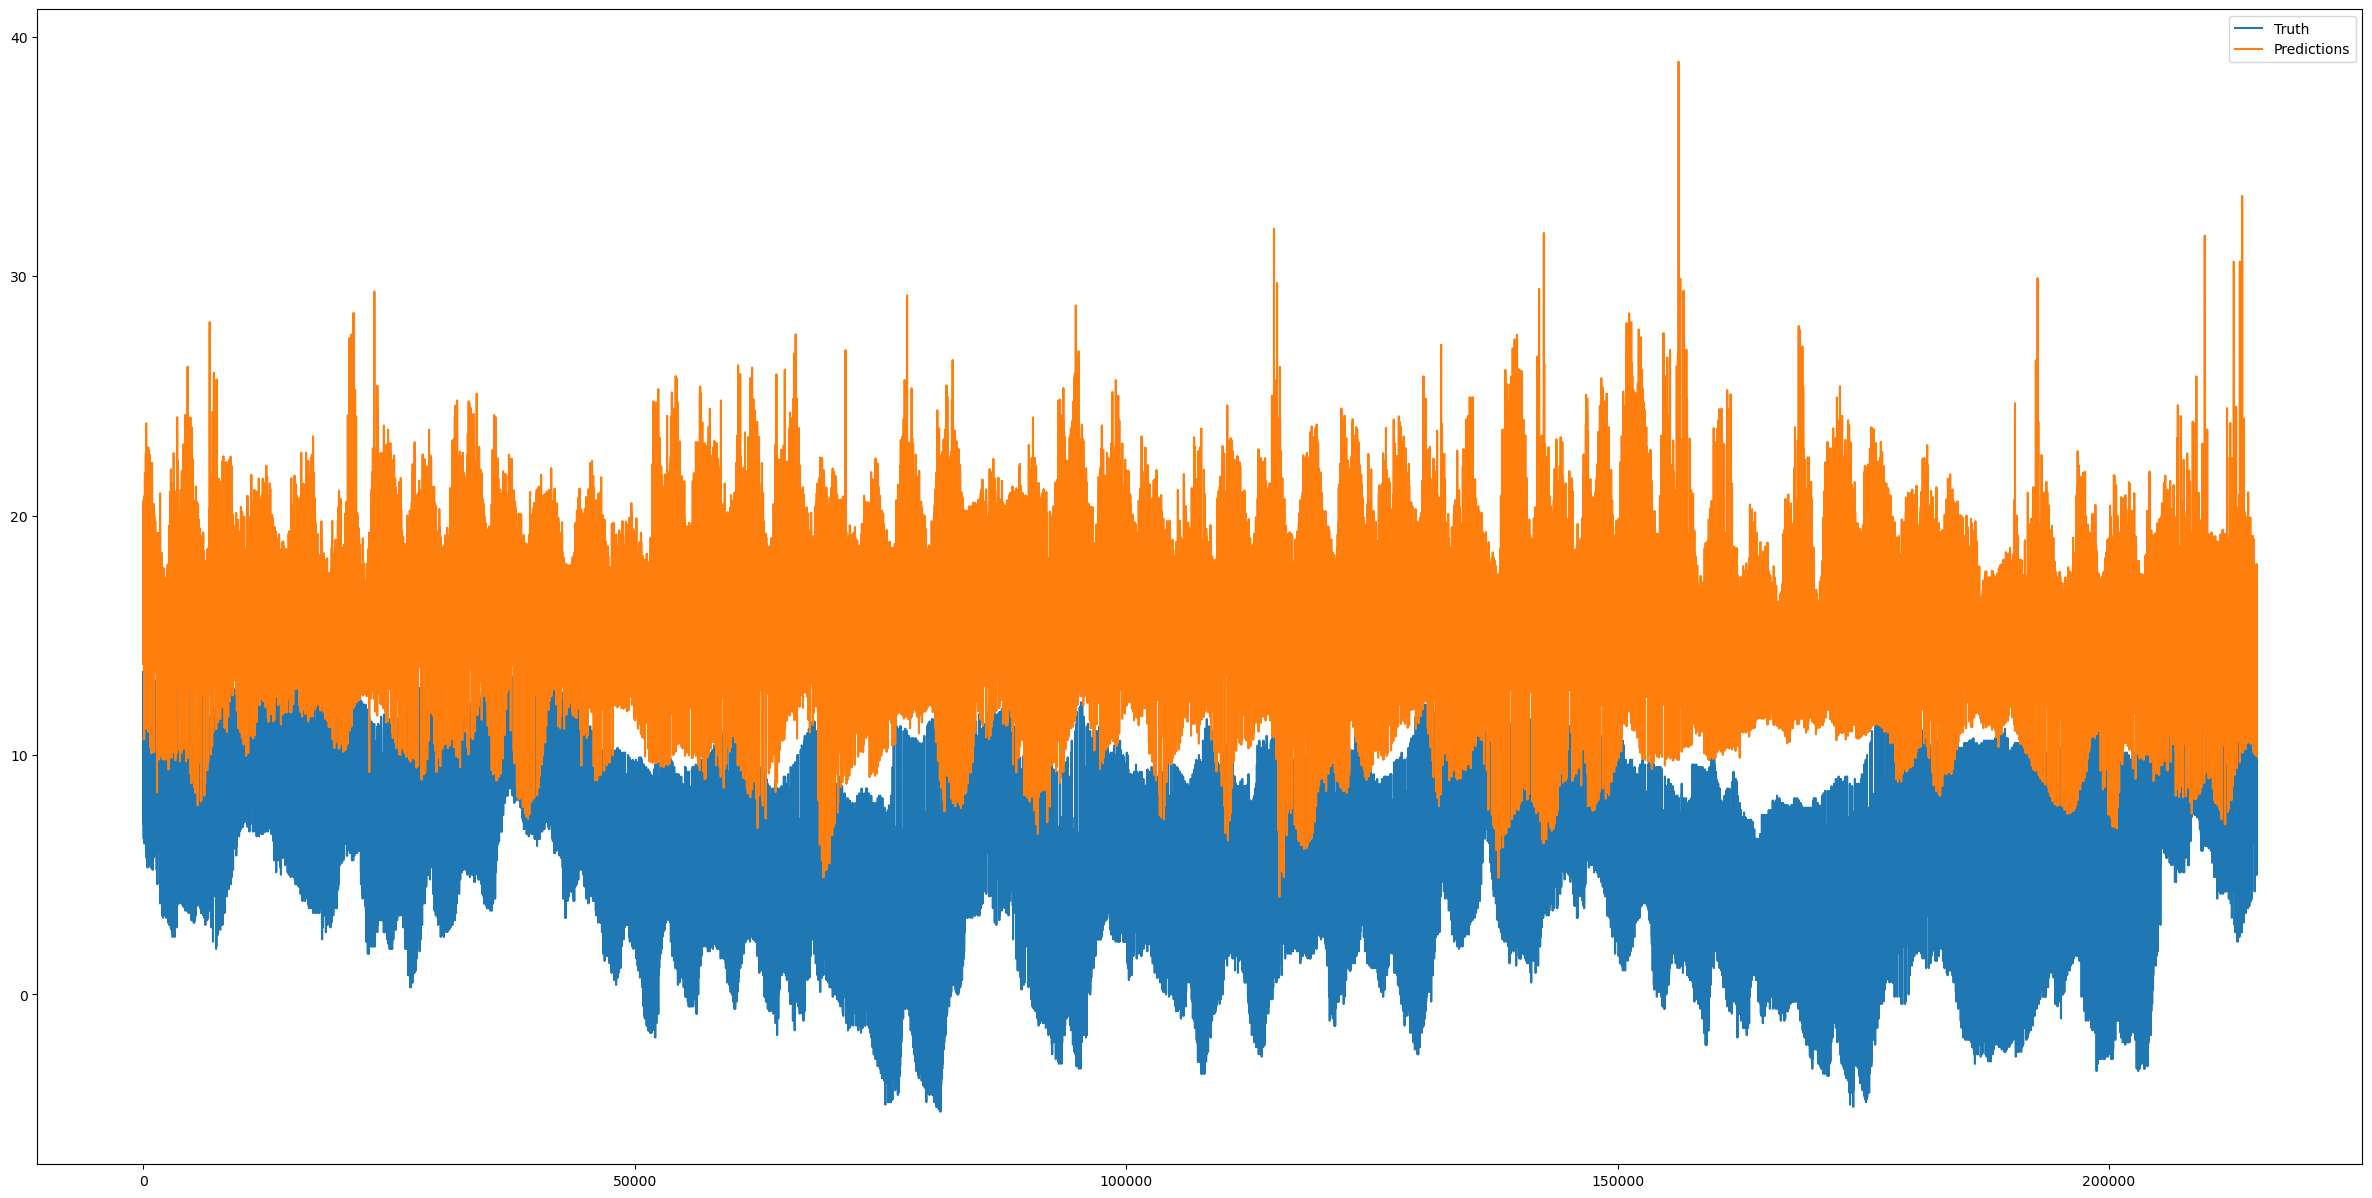

In [24]:
plt.plot(history.history["loss"])
plt.show()
#save_fig(name, "loss")

predictions = model.predict(test_data).flatten()

display(predictions)
plt.plot(test_targets.to_list(), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.show()
#save_fig(name, "predictions")

In [28]:
model.save("models")

INFO:tensorflow:Assets written to: models/temperature/1\assets


In [29]:
make_archive("temp_models", "zip", "models")

'c:\\Users\\ltrowbridge\\Documents\\COMP3000-Project-Machine-Learning\\temp_models.zip'